In [ ]:
from src.components.nn_data_ingestion import FraudDetectionDataset
from src.baseline.data_ingestion import DataIngestorFactory, DataIngestorConfig
from torch.utils.data import DataLoader
from src.baseline.features_engineering import PreprocessorPipeline
import pandas as pd
import os

In [2]:

os.chdir(rf"c:\Users\thuhi\workspace\fraud_detection")
print(os.getcwd())

factory = DataIngestorFactory()
ingestor = factory.create_ingestor("duration_pkl")
train_df, validation_df = ingestor.ingest(
    dir_path=rf"C:\Users\thuhi\workspace\fraud_detection\data\transformed_data",
    start_train_date="2018-07-01",
    train_duration=35,
    test_duration=30,
    delay=7
)

train_preprocessed = PreprocessorPipeline(train_df).process()
validation_preprocessed = PreprocessorPipeline(validation_df,add_method=["smote","scale"]).process()

c:\Users\thuhi\workspace\fraud_detection


In [3]:
train_data = FraudDetectionDataset(train_preprocessed, mode="transformed")
validation_data = FraudDetectionDataset(validation_preprocessed, mode="transformed")
batch_size = 2048
train_loader = DataLoader(
    train_data,
    batch_size=batch_size,
    shuffle=True,
    num_workers=8,
    persistent_workers=True
)
validation_loader = DataLoader(
    validation_data,
    batch_size=batch_size,
    num_workers=8,
    persistent_workers=True,
    shuffle=False)


In [4]:
import torch
from src.components.feed_forward_nn import Feed_Forward_NN

# Prepare test data
test_data = torch.tensor(validation_preprocessed[DataIngestorConfig.input_features_transformed].to_numpy(), dtype=torch.float32)
# Normalize if needed (replace with your training mean/std)
# mean = torch.tensor(train_mean)
# std = torch.tensor(train_std)
# test_data = (test_data - mean) / std

# Load the model
model = Feed_Forward_NN.load_from_checkpoint(
    rf"C:\Users\thuhi\workspace\fraud_detection\checkpoints\best-model-20250606_083429-bs2048-ep40-pat10-1.0-traindur35-testdur7-epoch=08-val_loss=0.24.ckpt",
    input_size=len(DataIngestorConfig.input_features_transformed),
    hidden_size=512,
    pos_weight = torch.tensor(train_preprocessed[DataIngestorConfig().output_feature].sum()
                              / (len(train_preprocessed) - train_preprocessed[DataIngestorConfig().output_feature].sum()))
)
model.eval()

# Move test data to the same device as the model
test_data = test_data.to(model.device)
print(f"Test data shape: {test_data.shape}")
print(f"Model device: {next(model.parameters()).device}")

# Predict with the model
with torch.no_grad():  # Disable gradient computation for inference
    y_hat = model(test_data)
    y_prob = torch.sigmoid(y_hat)  # Convert logits to probabilities
    y_pred = (y_prob > 0.5).float()  # Binary predictions

# Print some predictions
print(f"Predicted probabilities: {y_prob}")
print(f"Binary predictions: {y_pred}")

# Compute metrics (assuming you have validation_labels)


Test data shape: torch.Size([588400, 15])
Model device: cuda:0
Predicted probabilities: tensor([[4.8894e-05],
        [3.4507e-04],
        [4.3044e-04],
        ...,
        [9.9811e-01],
        [9.9999e-01],
        [1.0000e+00]], device='cuda:0')
Binary predictions: tensor([[0.],
        [0.],
        [0.],
        ...,
        [1.],
        [1.],
        [1.]], device='cuda:0')


In [8]:
predicted_proba = pd.DataFrame(y_prob.cpu())

validation_preprocessed["prob"] = predicted_proba

     AUCROC        F1  Top100k_Precision
0  0.971363  0.922031            0.99925


<Axes: xlabel='prob', ylabel='Count'>

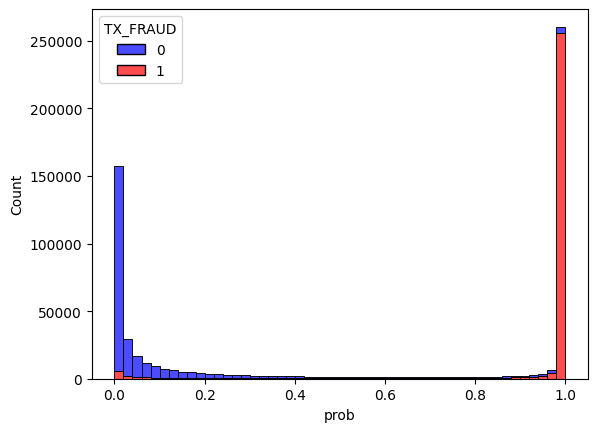

In [9]:
import seaborn as sns
from sklearn.metrics import roc_auc_score, f1_score, precision_score
# True labels and predicted probabilities
y_true = validation_preprocessed["TX_FRAUD"].values
y_scores = validation_preprocessed["prob"].values

# AUC-ROC
aucroc = roc_auc_score(y_true, y_scores)

# F1 score at threshold 0.5
y_pred_bin = (y_scores > 0.5).astype(int)
f1 = f1_score(y_true, y_pred_bin)

# Top 100k precision
top_k = 100_000
top_k_idx = y_scores.argsort()[-top_k:][::-1]
precision_top_k = precision_score(y_true[top_k_idx], y_pred_bin[top_k_idx])

# Report as DataFrame
metrics_df = pd.DataFrame({
    "AUCROC": [aucroc],
    "F1": [f1],
    "Top100k_Precision": [precision_top_k]
})
print(metrics_df)
sns.histplot(
    data=validation_preprocessed,
    x="prob",
    hue="TX_FRAUD",
    multiple="stack",
    bins=50,
    palette={0: "blue", 1: "red"},
    alpha=0.7
)

     AUCROC        F1  Top100k_Precision
0  0.722667  0.459519            0.39336
Middle range samples: 123760


<Axes: xlabel='prob', ylabel='Count'>

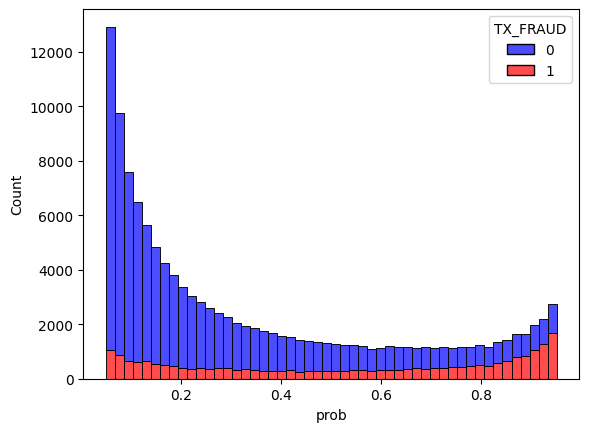

In [18]:
# Filter out rows where predicted probability is exactly 0 or 1
middle_range_df = validation_preprocessed[(validation_preprocessed["prob"] > 0.05) & (validation_preprocessed["prob"] < 0.95)]
# AUC-ROC
y_true = middle_range_df["TX_FRAUD"].values
y_scores = middle_range_df["prob"].values

aucroc = roc_auc_score(y_true, y_scores)

# F1 score at threshold 0.5
y_pred_bin = (y_scores > 0.5).astype(int)
f1 = f1_score(y_true, y_pred_bin)

# Top 100k precision
top_k = 100_000
top_k_idx = y_scores.argsort()[-top_k:][::-1]
precision_top_k = precision_score(y_true[top_k_idx], y_pred_bin[top_k_idx])

# Report as DataFrame
metrics_df = pd.DataFrame({
    "AUCROC": [aucroc],
    "F1": [f1],
    "Top100k_Precision": [precision_top_k]
})
print(metrics_df)
print(f"Middle range samples: {len(middle_range_df)}")
sns.histplot(
    data=middle_range_df,
    x="prob",
    hue="TX_FRAUD",
    multiple="stack",
    bins=50,
    palette={0: "blue", 1: "red"},
    alpha=0.7
)